In [1]:
import numpy as np

from commons import *
from dataset_loader import load_images, prepare_dataset
from IPython.display import display
import cv2
import pickle
import matplotlib.pyplot as plt
from keras.models import load_model


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'
ARTIFACTS_SRC = 'hit-images-final2/artefact'

DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/tracks_100000.h5'
WORMS_AC = 'cache/worms_100000.h5'
ARTIFACTS_AC = 'cache/artifacts_100000.h5'



dots_set =  prepare_dataset(load_images(DOTS_SRC))
worms_set =  prepare_dataset(load_images(WORMS_SRC))
tracks_set =  prepare_dataset(load_images(TRACKS_SRC))
artifacts_set =  prepare_dataset(load_images(ARTIFACTS_SRC))

dots_autoencoder = load_model(DOTS_AC)
worms_autoencoder = load_model(WORMS_AC)
tracks_autoencoder = load_model(TRACKS_AC)
artifacts_autoencoder = load_model(ARTIFACTS_AC)

on = {'dots': calc_similarity(dots_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'worms': calc_similarity(worms_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'tracks': calc_similarity(tracks_autoencoder, dots_set, tracks_set, worms_set, artifacts_set),
      'artifacts': calc_similarity(artifacts_autoencoder, dots_set, tracks_set, worms_set, artifacts_set)}

Channel dots, compare dots vs tracks, threshold: -11.091067446192564, fp/fn percent: 4.008097165991903 %


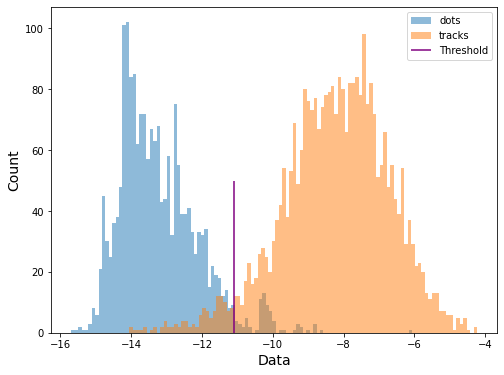

Channel dots, compare dots vs worms, threshold: -10.573970699310186, fp/fn percent: 3.1210459721636443 %


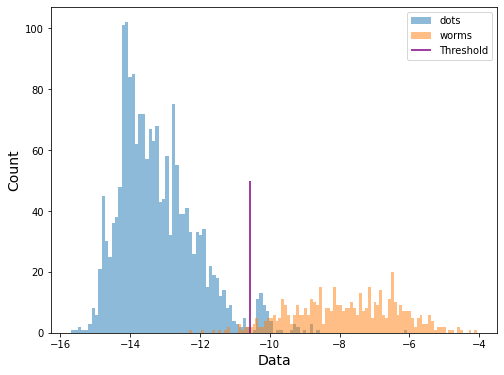

Channel dots, compare dots vs artifacts, threshold: -11.024019059935114, fp/fn percent: 3.8476794922649744 %


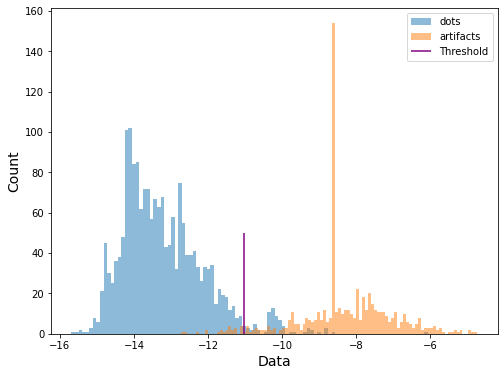

Channel tracks, compare tracks vs dots, threshold: -10.955507555822095, fp/fn percent: 44.534412955465584 %


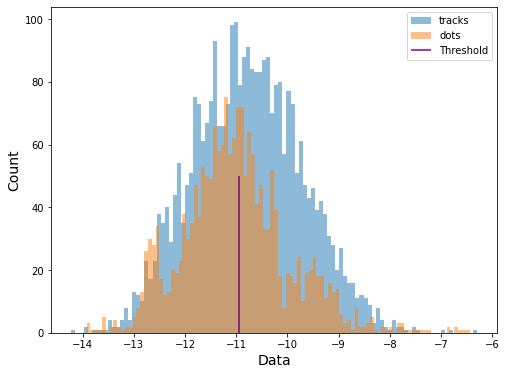

Channel tracks, compare tracks vs worms, threshold: -9.966255282126667, fp/fn percent: 22.97107554057849 %


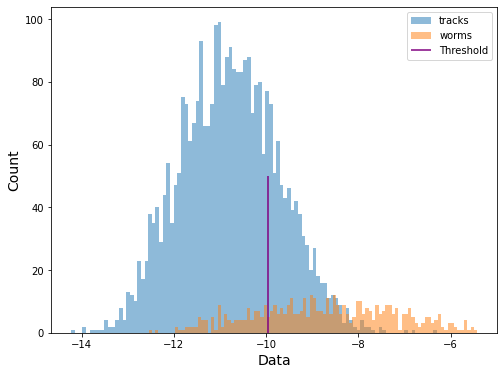

Channel tracks, compare tracks vs artifacts, threshold: -9.663373880992932, fp/fn percent: 15.009431420102398 %


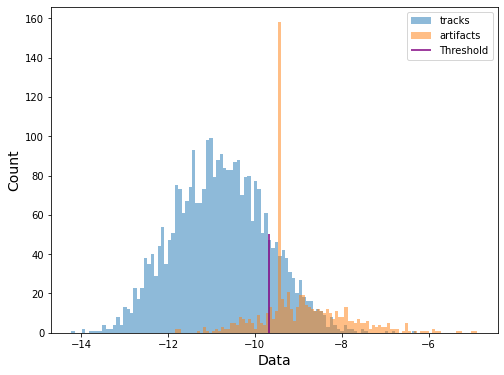

Channel worms, compare worms vs dots, threshold: -10.160129517056848, fp/fn percent: 49.388443694643605 %


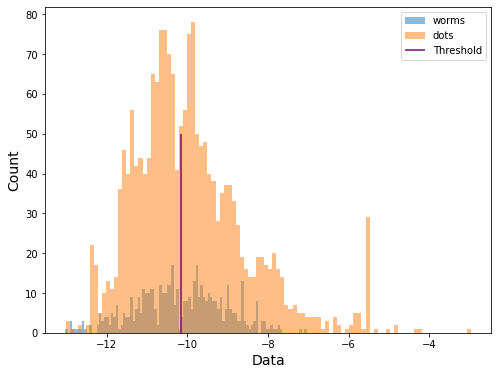

Channel worms, compare worms vs tracks, threshold: -9.708151758221149, fp/fn percent: 35.43948329121033 %


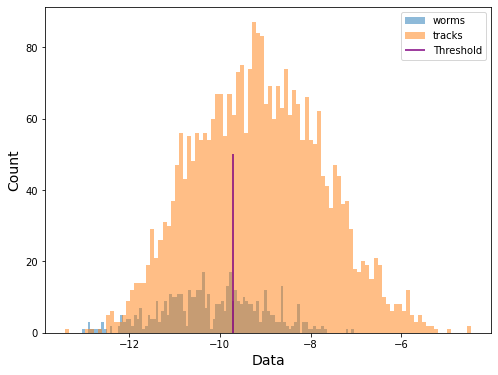

Channel worms, compare worms vs artifacts, threshold: -9.273946395059738, fp/fn percent: 22.066549912434326 %


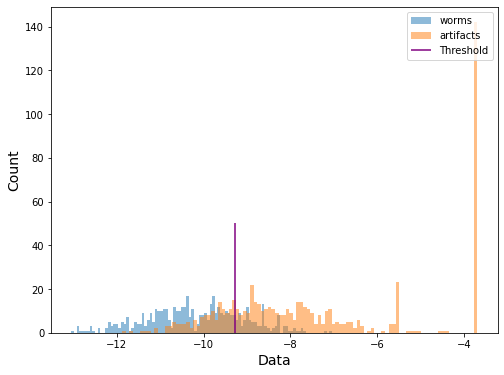

Channel artifacts, compare artifacts vs dots, threshold: -6.878702253865454, fp/fn percent: 45.180483934946444 %


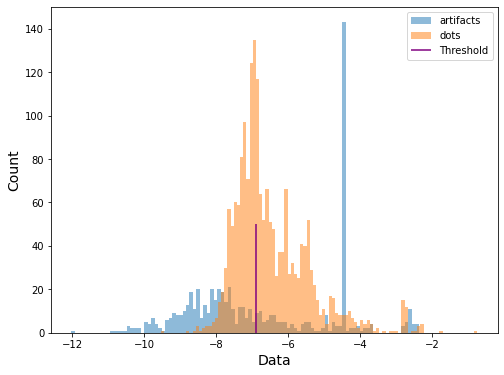

Channel artifacts, compare artifacts vs tracks, threshold: -7.298838663708452, fp/fn percent: 48.31581783885745 %


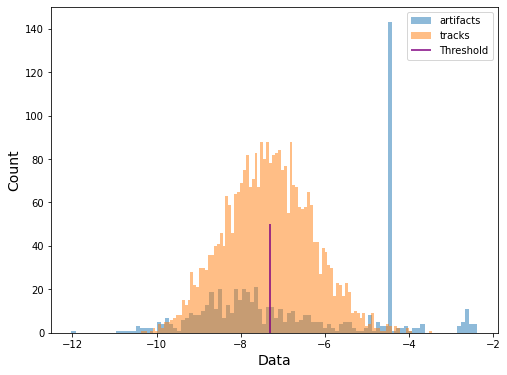

Channel artifacts, compare artifacts vs worms, threshold: -7.304508589961128, fp/fn percent: 48.161120840630474 %


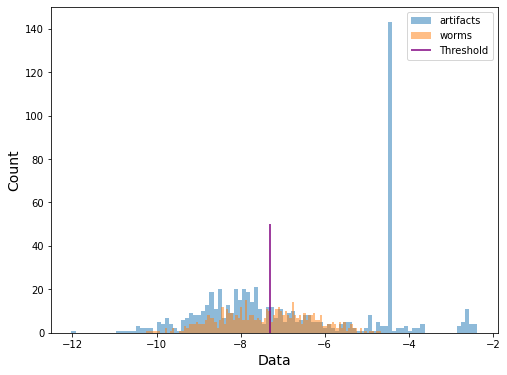

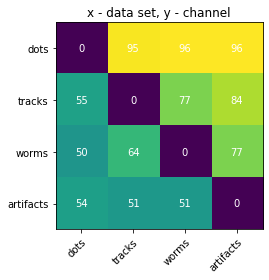

In [2]:
confusion_matrix(on)